# Spotify Hit Classification

In this notebook I will attempt to build a classifier that determines how likely a song is to become a hit. The data comes from "The Spotify Hit Predictor Dataset (1960-2019)" on Kaggle.

## Data Description

- **Track**: The Name of the track.

- **Artist**: The Name of the Artist.

- **URI**: The resource identifier for the track.

- **Danceability**: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable. 

- **Energy**: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy. 

- **Key**: The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C?/D?, 2 = D, and so on. If no key was detected, the value is -1.

- **Loudness**: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db. 

- **Mode**: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

- **Speechiness**: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks. 

- **Acousticness**: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic. The distribution of values for this feature look like this:

- **Instrumentalness**: Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0. The distribution of values for this feature look like this:

- **Liveness**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

- **Valence**: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

- **Tempo**: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration. 

- **Duration_Ms**:  The duration of the track in milliseconds.

- **TimeSignature**: An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).

- **Chorus_Hit**: This the the author's best estimate of when the chorus would start for the track. Its the timestamp of the start of the third section of the track. This feature was extracted from the data received by the API call for Audio Analysis of that particular track.

- **Sections**: The number of sections the particular track has. This feature was extracted from the data received by the API call for Audio Analysis of that particular track.

- **Target**: The target variable for the track. It can be either '0' or '1'. '1' implies that this song has featured in the weekly list (Issued by Billboards) of Hot-100 tracks in that decade at least once and is therefore a 'hit'. '0' Implies that the track is a 'flop'.

      The author's condition of a track being 'flop' is as follows:

        - The track must not appear in the 'hit' list of that decade.
        - The track's artist must not appear in the 'hit' list of that decade.
        - The track must belong to a genre that could be considered non-mainstream and / or avant-garde. 
        - The track's genre must not have a song in the 'hit' list.
        - The track must have 'US' as one of its markets.

## Imports

In [60]:
import os
os.chdir(r"C:\Users\tom.dawson\Documents\Git Projects\SpotifyMusicData")
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from optbinning import OptimalBinning
import math
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.preprocessing import OrdinalEncoder
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, recall_score, precision_score, accuracy_score, confusion_matrix
from sklearn import tree, svm
from sklearn.datasets import load_iris
import graphviz
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from SpotifyFunctions import DistributionPlot, Scatter, Distribution, BinVariable, Correlation, BarPlot

## Data Processing

To start, we iterate over each csv file in the directory and add to the main DataFrame along with a new column for identifying trends over time. We then standardise column names to have an uppercase first letter and define some new variables based on the data spec.

We then define the groups of continuous and discrete variable groups (for ease of plotting) and, finally, split the data into a randomly shuffled train and test split.

In [2]:
#Misc
Csv = ["dataset-of-60s", "dataset-of-70s", "dataset-of-80s", "dataset-of-90s", "dataset-of-00s", "dataset-of-10s"] 
Data = pd.DataFrame()

for Set in Csv:
    Temp = pd.read_csv(f"DataSets\{Set}.csv")
    Temp["decade"] = [Set.split("-")[-1].replace("s",'')]*len(Temp)

    Data = Data.append(Temp)
    
for Column in Data.columns.values:
    Data[str(Column).title()] = Data[Column]
    del Data[Column]
    
Data["LowEnergy"] = Data["Energy"].apply(lambda x: 1 if x <= 0.2 else 0)
Data["Acoustic"] = Data["Acousticness"].apply(lambda x: 1 if x >= 0.8 else 0)
Data["FourFour"] = Data["Time_Signature"].apply(lambda x: 1 if x == 4 else 0)
    
    
ContinuousVars = ['Danceability', 'Energy', 'Loudness', 'Speechiness',
                   'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo',
                   'Duration_Ms', 'Chorus_Hit', 'Sections']

DiscreteVars = ["Time_Signature", "Mode", "Key", "Acoustic", "FourFour", "LowEnergy"]

# Split to train test
Data["Population"] = np.random.randint(1, 100, len(Data))
Data["Population"] = Data["Population"].apply(lambda x: "Train" if x <= 80 else "Test")

Train = Data.copy()
Test = Data.copy()
Train = Train[(Train["Population"] == "Train")]
Test = Test[(Test["Population"] == "Test")]

In [3]:
Train.columns.values

array(['Track', 'Artist', 'Uri', 'Danceability', 'Energy', 'Key',
       'Loudness', 'Mode', 'Speechiness', 'Acousticness',
       'Instrumentalness', 'Liveness', 'Valence', 'Tempo', 'Duration_Ms',
       'Time_Signature', 'Chorus_Hit', 'Sections', 'Target', 'Decade',
       'LowEnergy', 'Acoustic', 'FourFour', 'Population'], dtype=object)

## EDA

Key points that stand out:

- Some mixes have greater than 0 Decibels (Loudness/Amplitude), which is typically a no-go in music production.
- Most datapoints are in Major (Mode), which is typically a happier sound.

In [4]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33220 entries, 0 to 6397
Data columns (total 24 columns):
Track               33220 non-null object
Artist              33220 non-null object
Uri                 33220 non-null object
Danceability        33220 non-null float64
Energy              33220 non-null float64
Key                 33220 non-null int64
Loudness            33220 non-null float64
Mode                33220 non-null int64
Speechiness         33220 non-null float64
Acousticness        33220 non-null float64
Instrumentalness    33220 non-null float64
Liveness            33220 non-null float64
Valence             33220 non-null float64
Tempo               33220 non-null float64
Duration_Ms         33220 non-null int64
Time_Signature      33220 non-null int64
Chorus_Hit          33220 non-null float64
Sections            33220 non-null int64
Target              33220 non-null int64
Decade              33220 non-null object
LowEnergy           33220 non-null int64
Acousti

In [5]:
Train.describe()

Danceability        Energy           Key      Loudness          Mode  \
count  33220.000000  33220.000000  33220.000000  33220.000000  33220.000000   
mean       0.540094      0.579706      5.217068    -10.217374      0.691722   
std        0.177696      0.252465      3.536352      5.299739      0.461789   
min        0.000000      0.000251      0.000000    -49.253000      0.000000   
25%        0.421000      0.396000      2.000000    -12.817000      0.000000   
50%        0.552000      0.602000      5.000000     -9.248000      1.000000   
75%        0.669000      0.787000      8.000000     -6.389000      1.000000   
max        0.988000      1.000000     11.000000      3.744000      1.000000   

        Speechiness  Acousticness  Instrumentalness      Liveness  \
count  33220.000000  33220.000000      33220.000000  33220.000000   
mean       0.073239      0.363812          0.153692      0.201675   
std        0.086900      0.338045          0.303124      0.172910   
min        0.000000      0.000000          0.000000      0.013600   
25%        0.033700      0.039900          0.000000      0.094100   
50%        0.043400      0.259000          0.000117      0.132500   
75%        0.070100      0.673000          0.058725      0.261000   
max        0.960000      0.996000          1.000000      0.997000   

            Valence         Tempo   Duration_Ms  Time_Signature    Chorus_Hit  \
count  33220.000000  33220.000000  3.322000e+04    33220.000000  33220.000000   
mean       0.542031    119.432469  2.350661e+05        3.892926     40.187234   
std        0.267191     29.116196  1.167147e+05        0.425352     19.120432   
min        0.000000      0.000000  1.562900e+04        0.000000      0.000000   
25%        0.330000     97.514250  1.734115e+05        4.000000     27.665052   
50%        0.558000    117.673000  2.179135e+05        4.000000     35.896625   
75%        0.766000    136.709500  2.670702e+05        4.000000     47.652763   
max        0.996000    241.423000  3.816373e+06        5.000000    433.182000   

           Sections        Target     LowEnergy      Acoustic      FourFour  
count  33220.000000  33220.000000  33220.000000  33220.000000  33220.000000  
mean      10.485731      0.501355      0.091120      0.165593      0.881517  
std        4.811921      0.500006      0.287784      0.371720      0.323184  
min        0.000000      0.000000      0.000000      0.000000      0.000000  
25%        8.000000      0.000000      0.000000      0.000000      1.000000  
50%       10.000000      1.000000      0.000000      0.000000      1.000000  
75%       12.000000      1.000000      0.000000      0.000000      1.000000  
max      145.000000      1.000000      1.000000      1.000000      1.000000

## Distributions

From the distribution plots, we can see many examples of the way in which our features interact with the target.

- We see that in general, hits tend to be more Danceable, this makes sense in general due to pop music typically being the type that people dance to.

- We see the same for energy - songs with more energy are more likely to be hits. Although, up to extreme levels of energy we see a drop in the volume of hits. This is possibly down to them correlating with certain genres like Metal or Heavy Dance music.

- As expected, louder mixes tend to make better hits than quieter. In the industry, producers (especially nowadays) tend to strive for louder and louder mixes.

- Very Acoustic songs tend not to make very good hits, this is possibly down to the low energy that often comes with these songs, these variables could possibly correlate with one another.

- Happier songs tend to make better hits, this is to be expected due to the positive impact happy songs can have on the listener.

- There is a clear sweet spot for duration, which definitely makes sense - listener attention span, radio conventions etc.

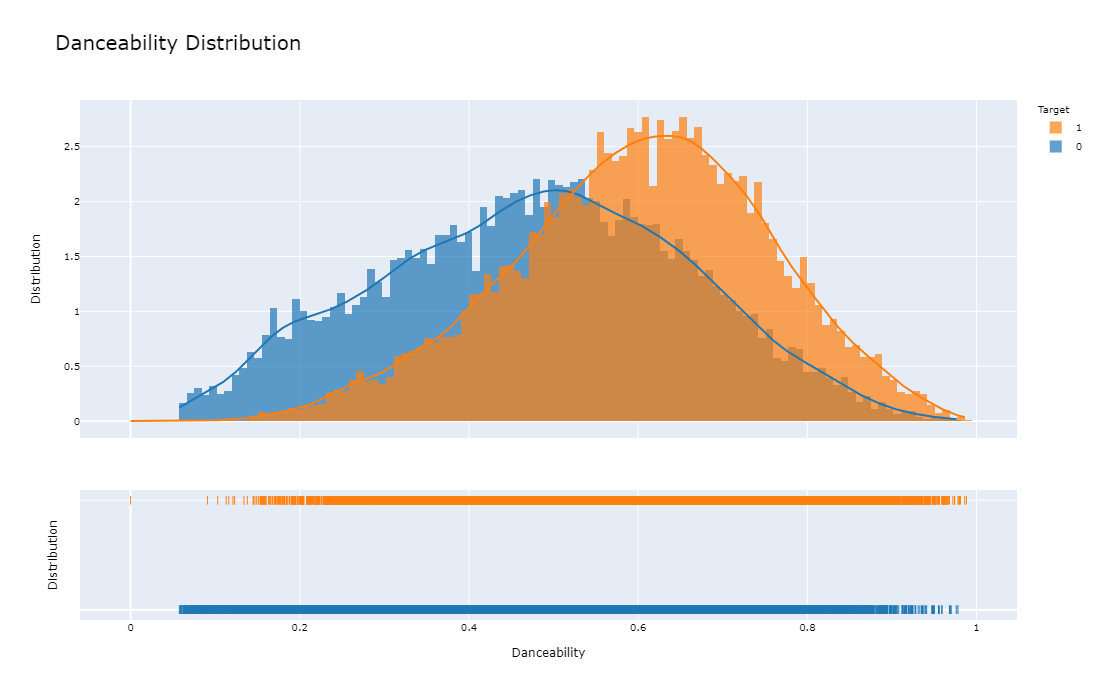

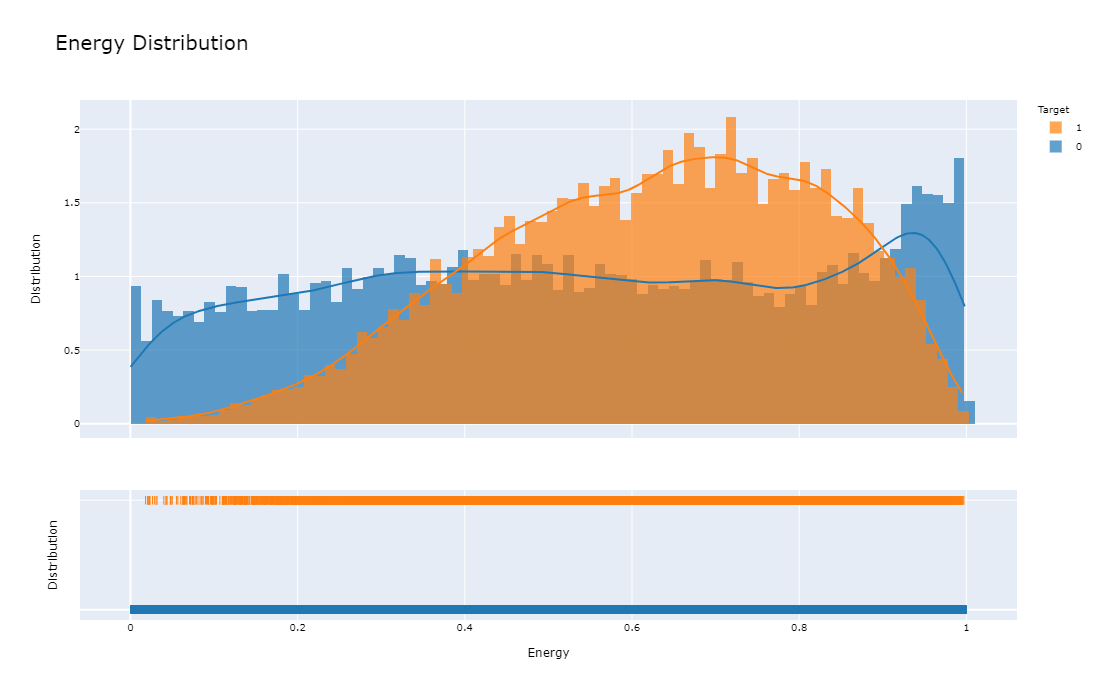

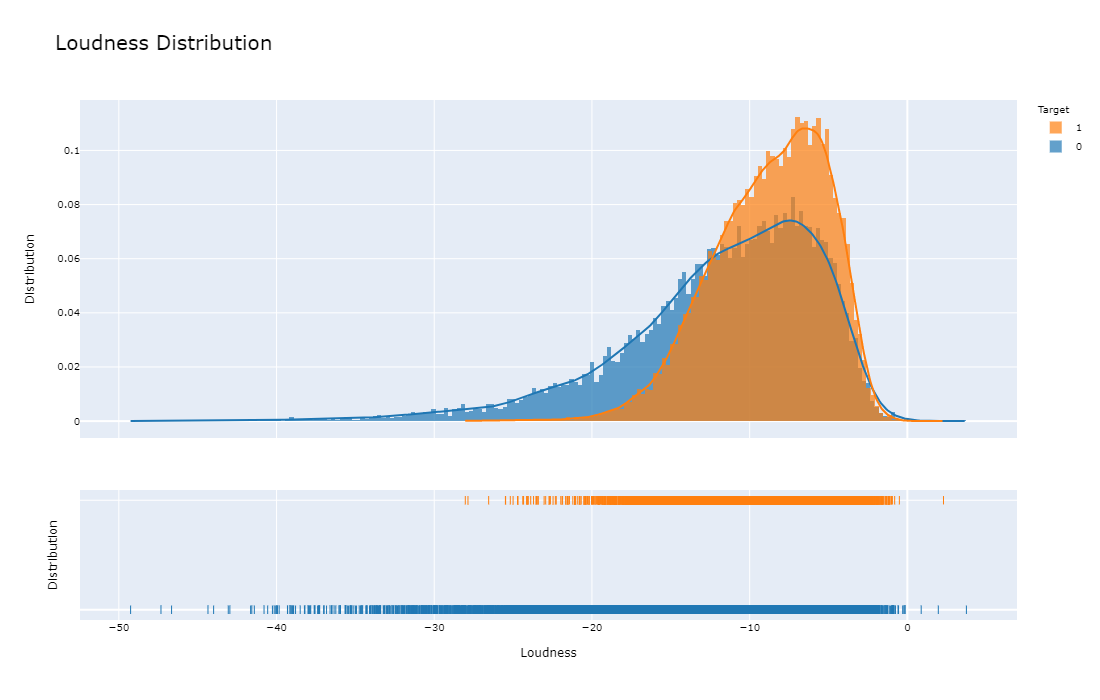

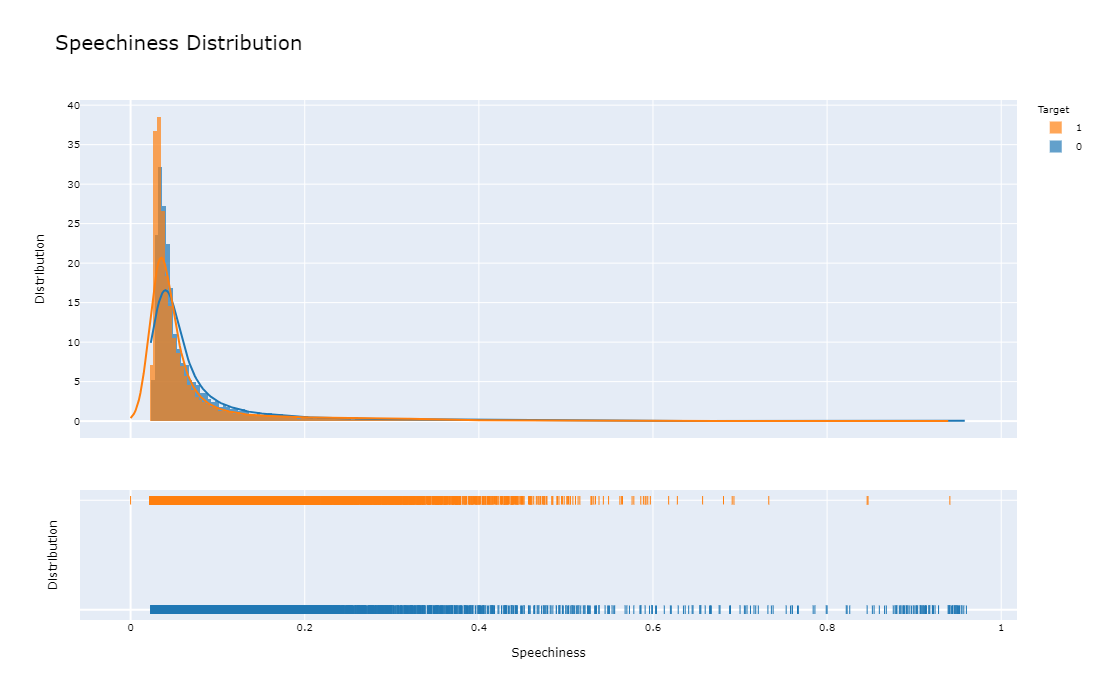

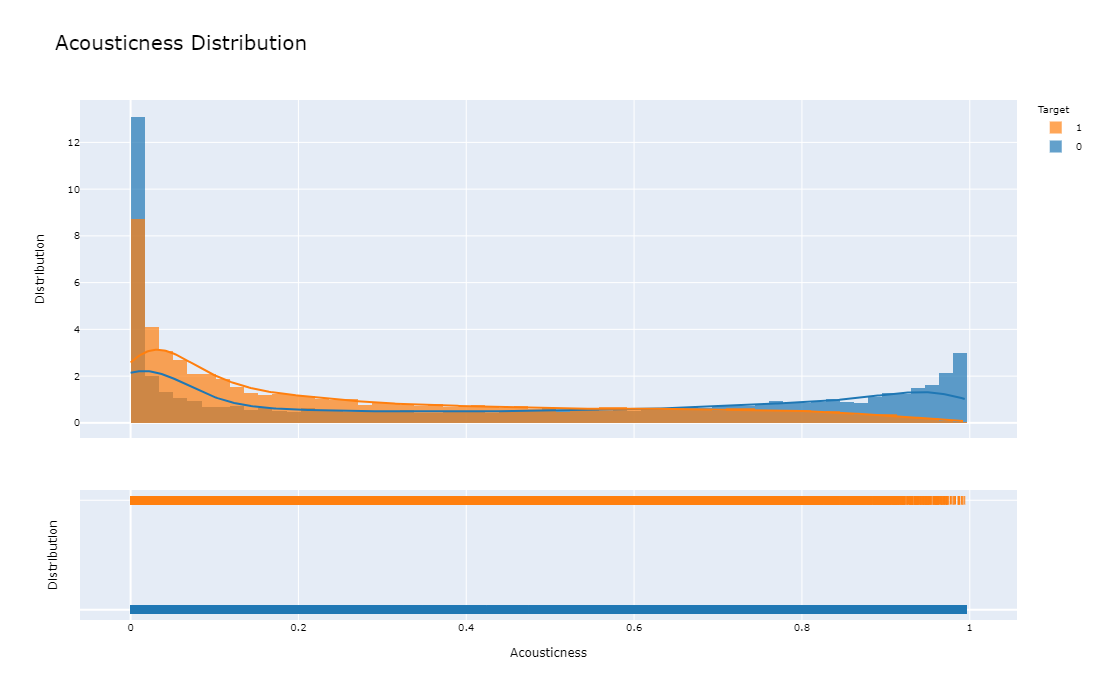

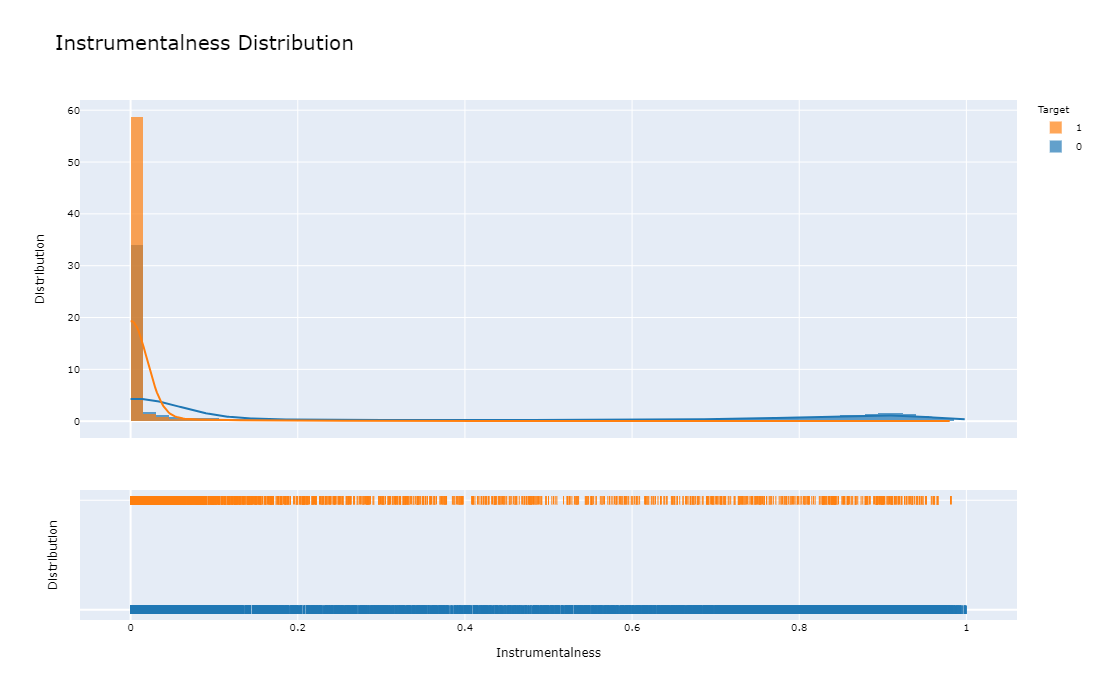

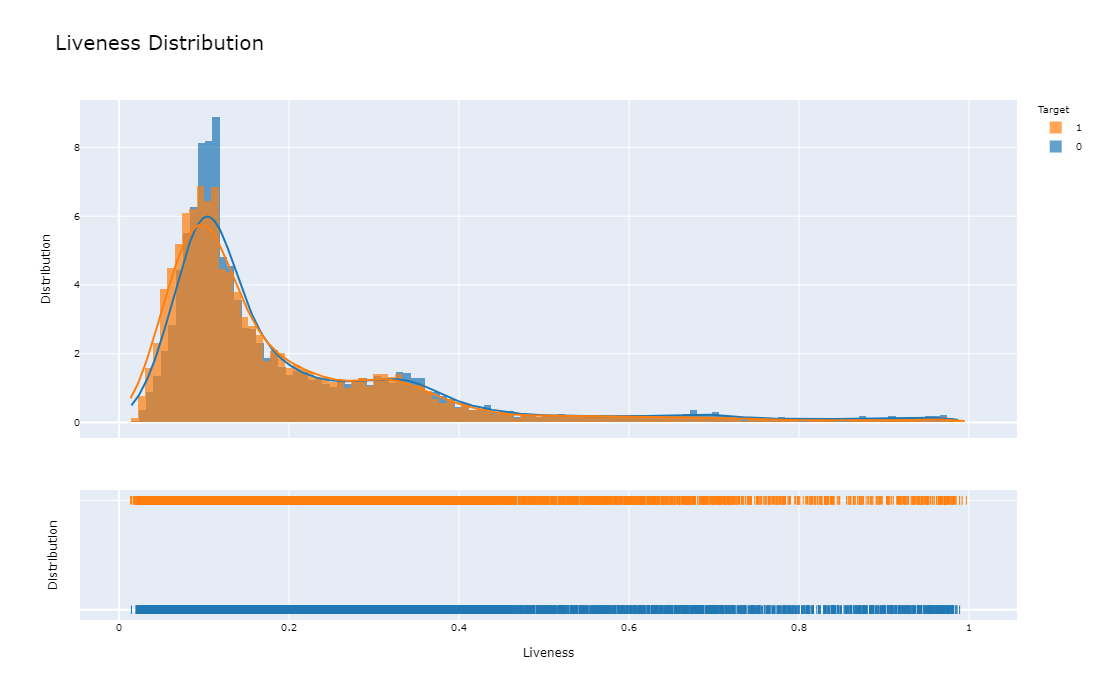

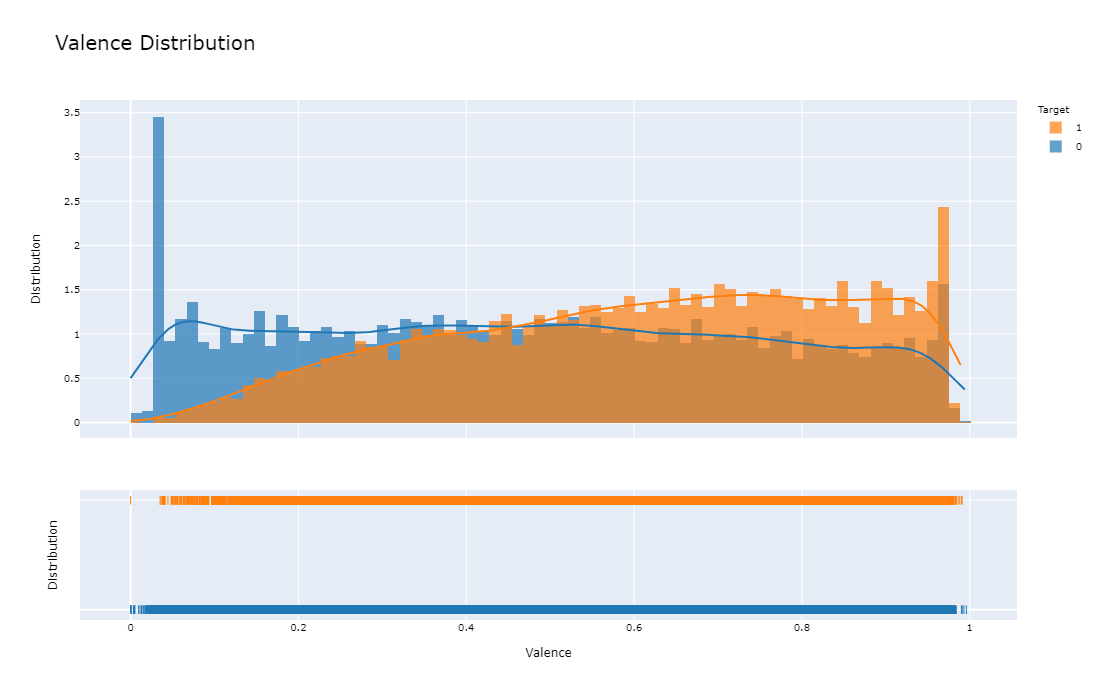

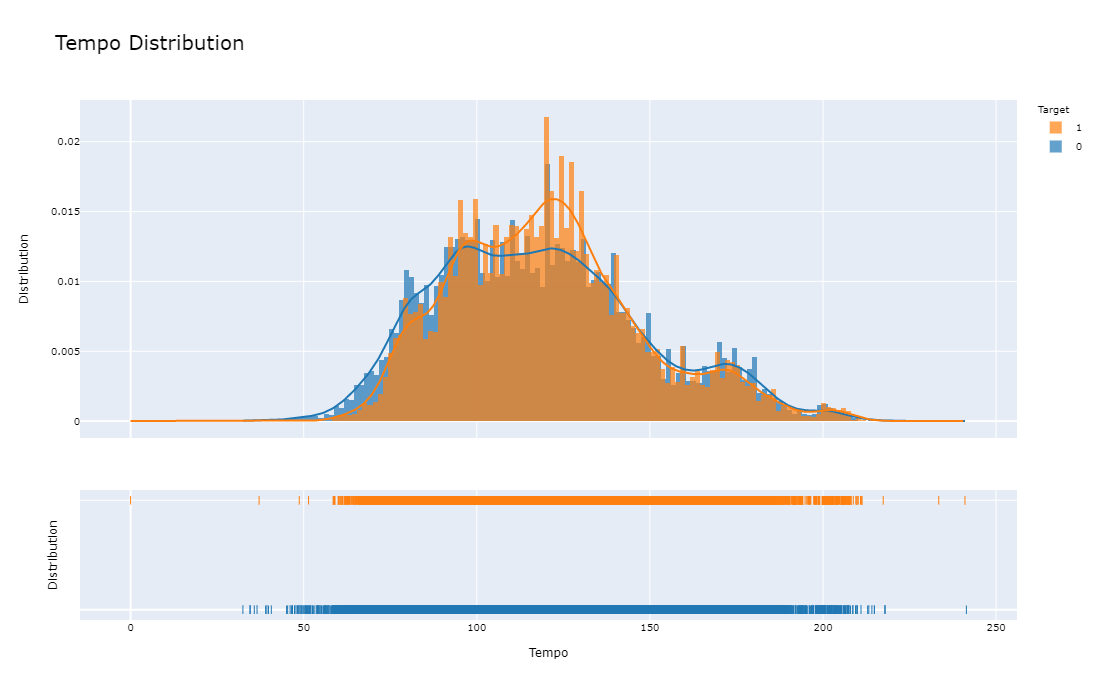

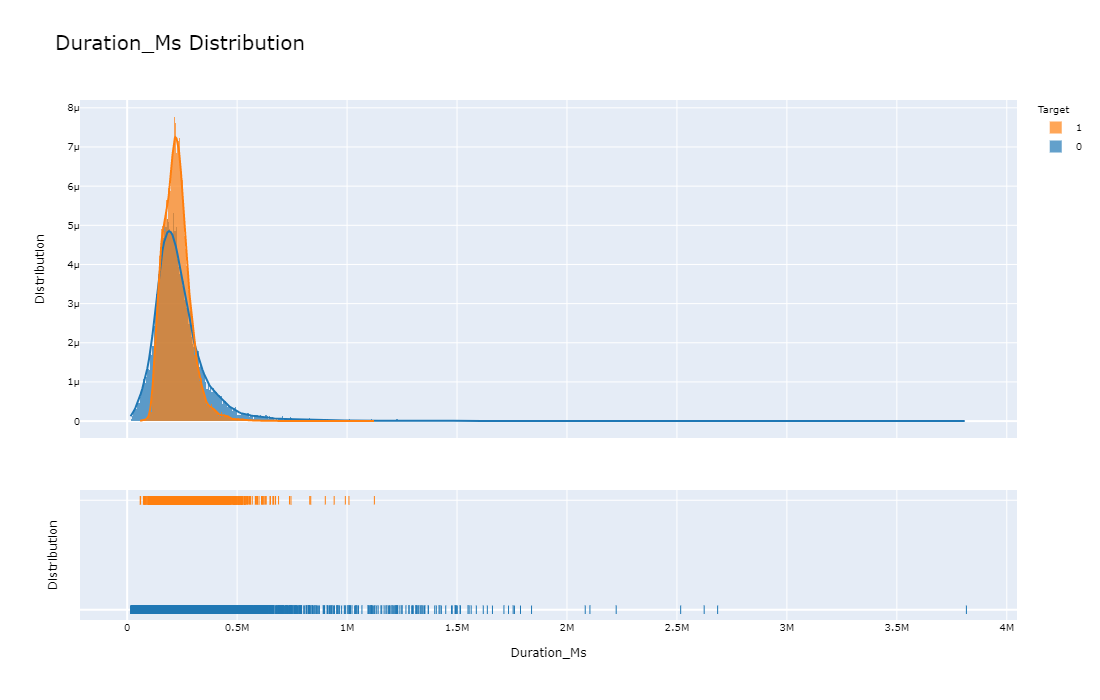

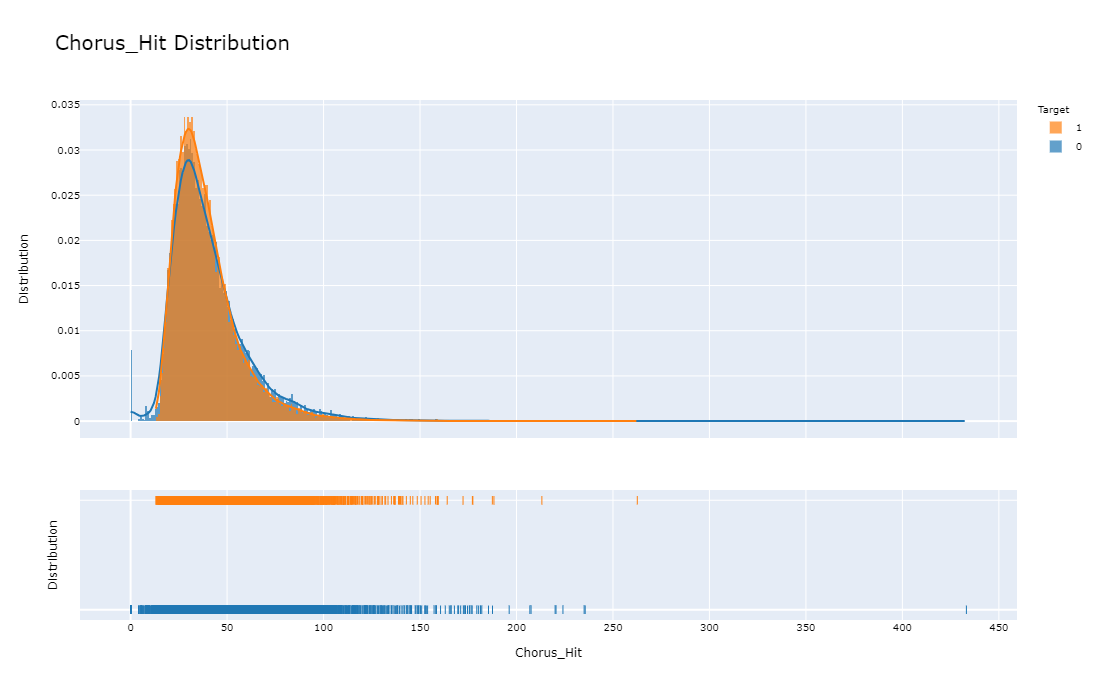

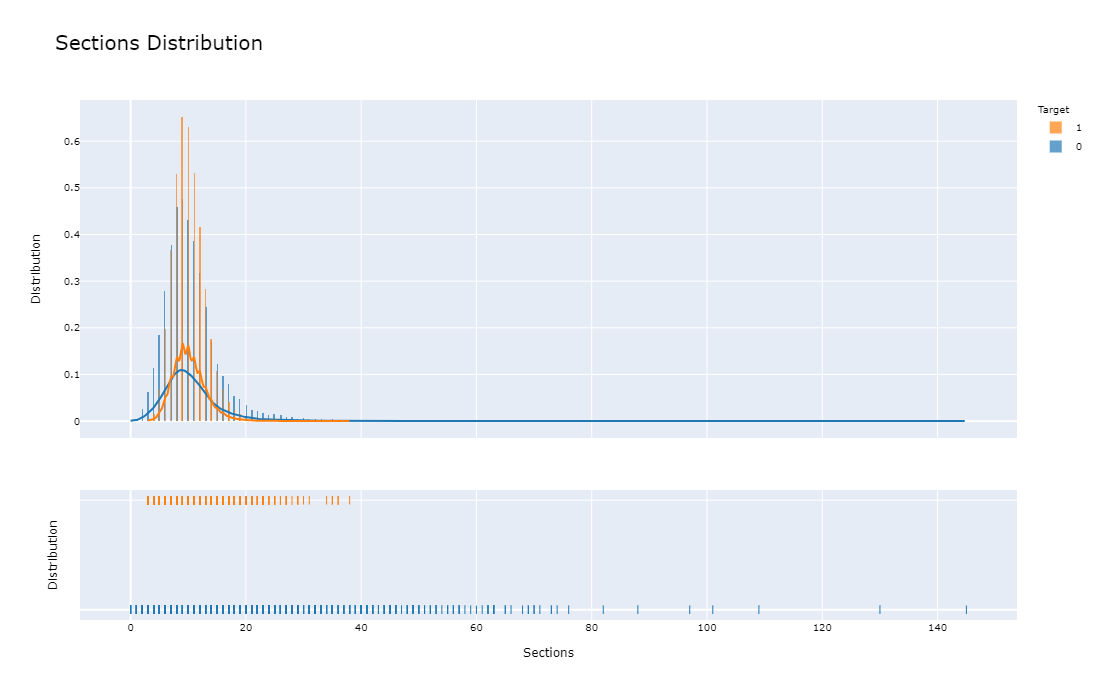

In [6]:
for Var in ContinuousVars:
    DistributionPlot(Train, Var)

## Testing combined variable impact on Target

- Songs that are hits tend to be more danceable and have higher energy together (No-Brainer)
- High Energy but undanceable songs are less likely to be hits, maybe particular Rock/Metal genres?
- Low energy Acoustic Songs tend to be Flops

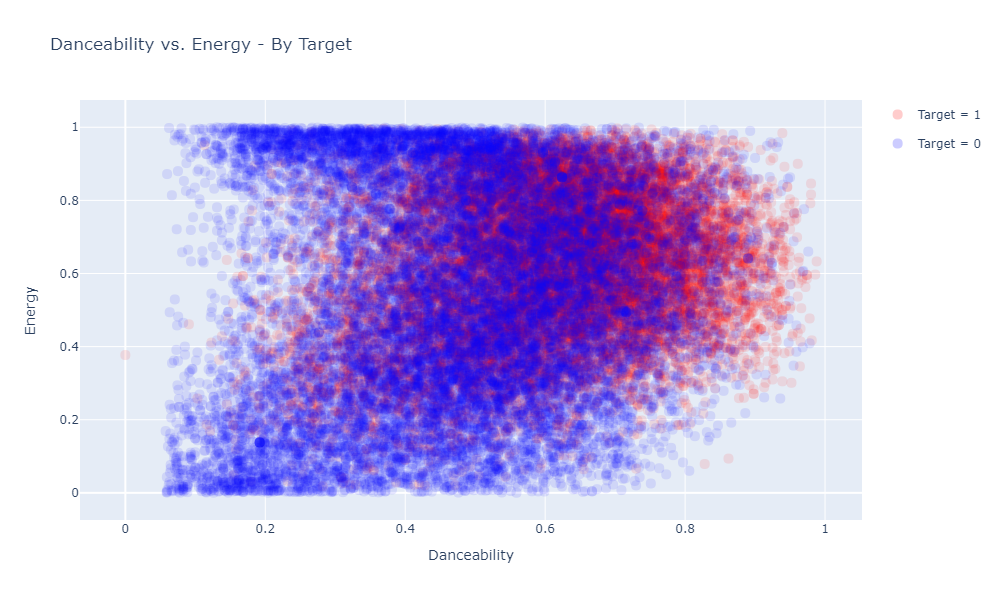

In [7]:
Scatter(Train, "Danceability", "Target", "Energy", "Danceability vs. Energy - By Target")

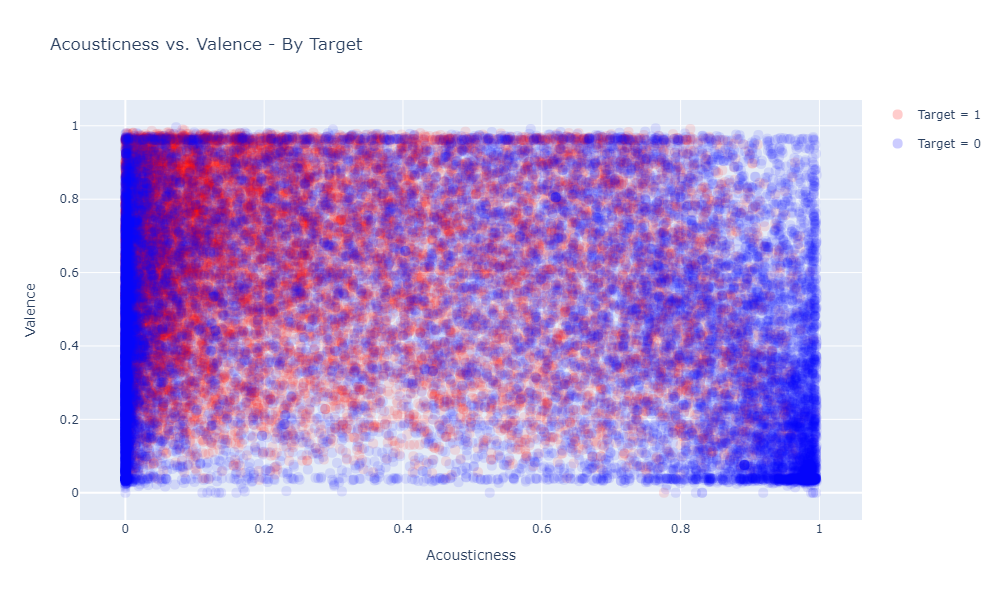

In [8]:
#Very Acoustic Songs that are also sad are not likely to be hits
Scatter(Train, "Acousticness", "Target", "Valence", "Acousticness vs. Valence - By Target")

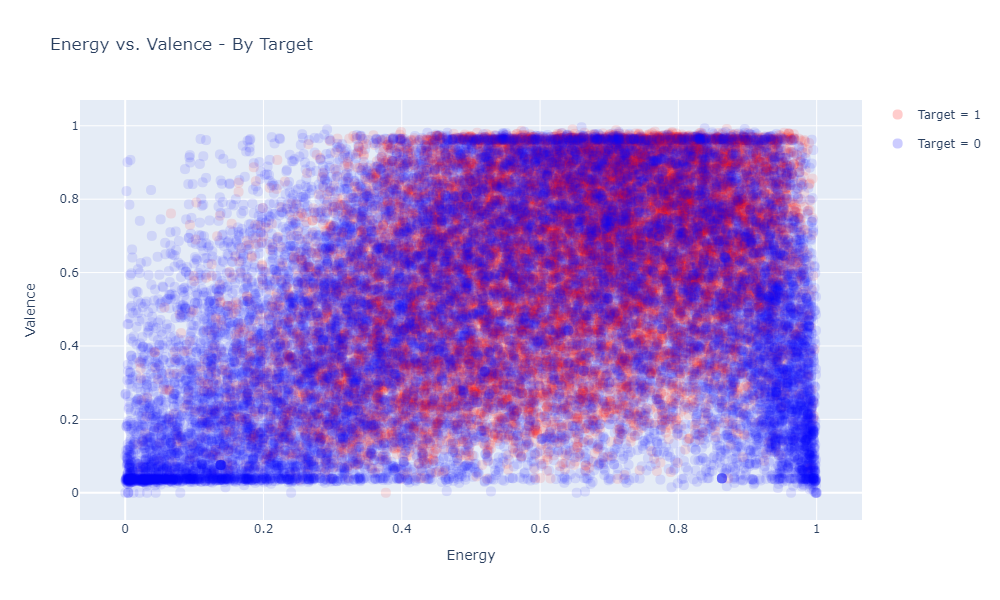

In [9]:
Scatter(Train, "Energy", "Target", "Valence", "Energy vs. Valence - By Target")

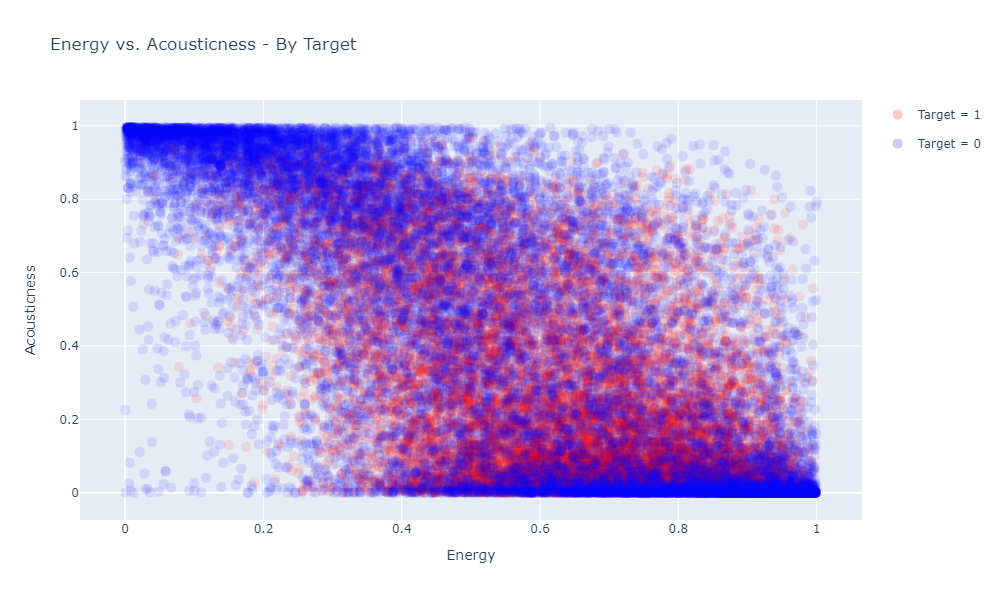

In [10]:
Scatter(Train, "Energy", "Target", "Acousticness", "Energy vs. Acousticness - By Target")

## Bin Variables and Clean
- We can see that, obviously, the most common signature is 4:4.
- We also see the host of non-linear relationships between features and the Target.

We use the optimal binning library in python to find the most optimal ways of binning our variables w.r.t the target. We bin our variables according to these definitions and scale them between 0 and 1, to help with gradient descent and assessing our feature importance.

We also ordinally encode the "Key" variable according to its relationship with the target.

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




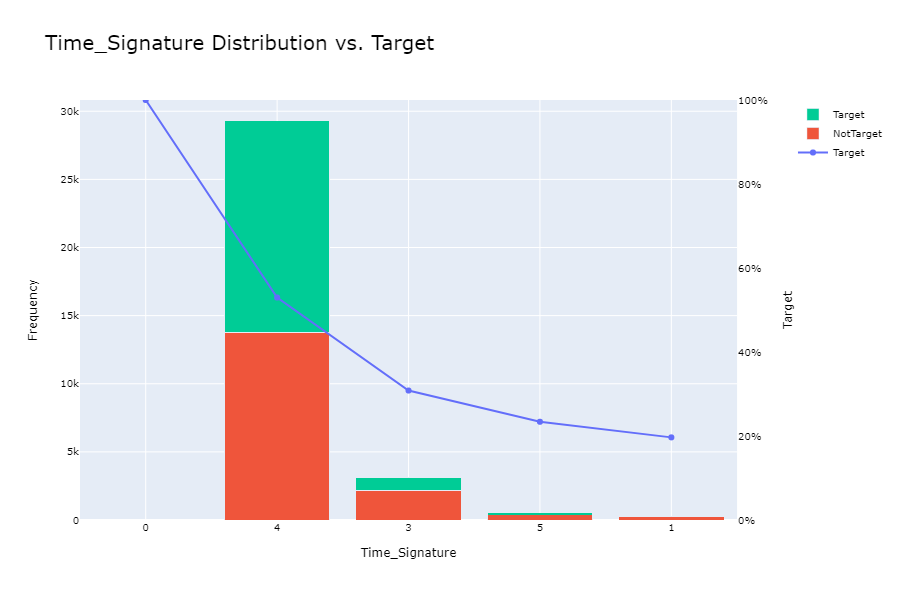

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




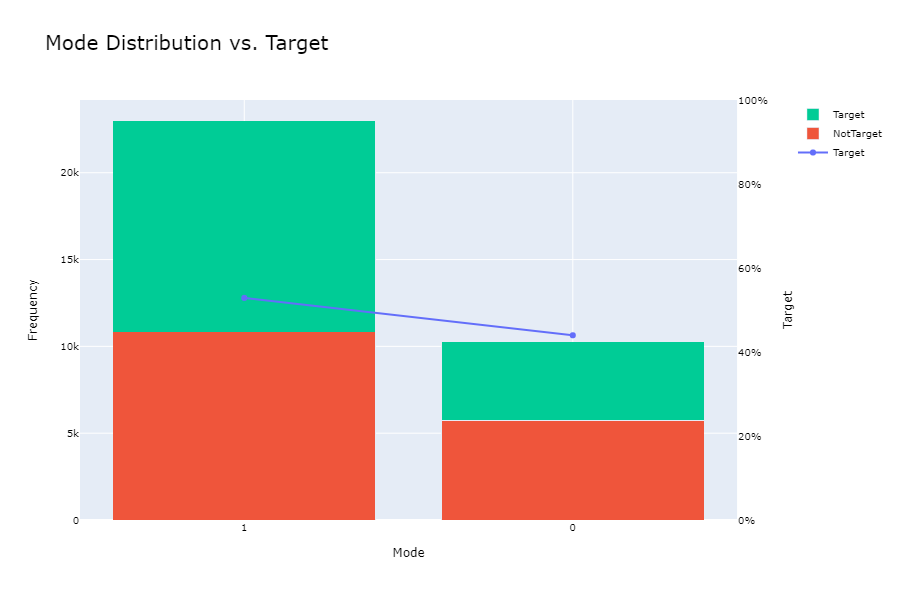

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




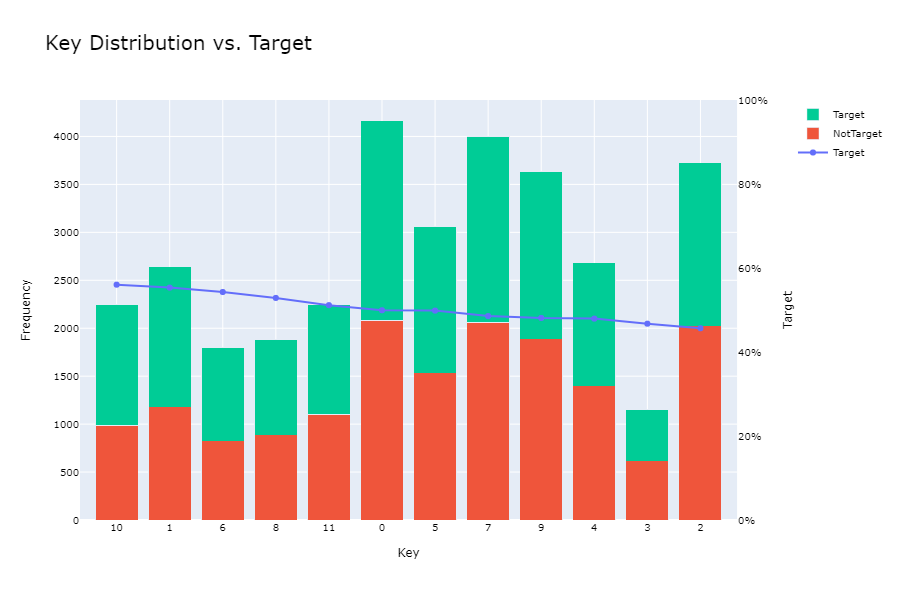

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




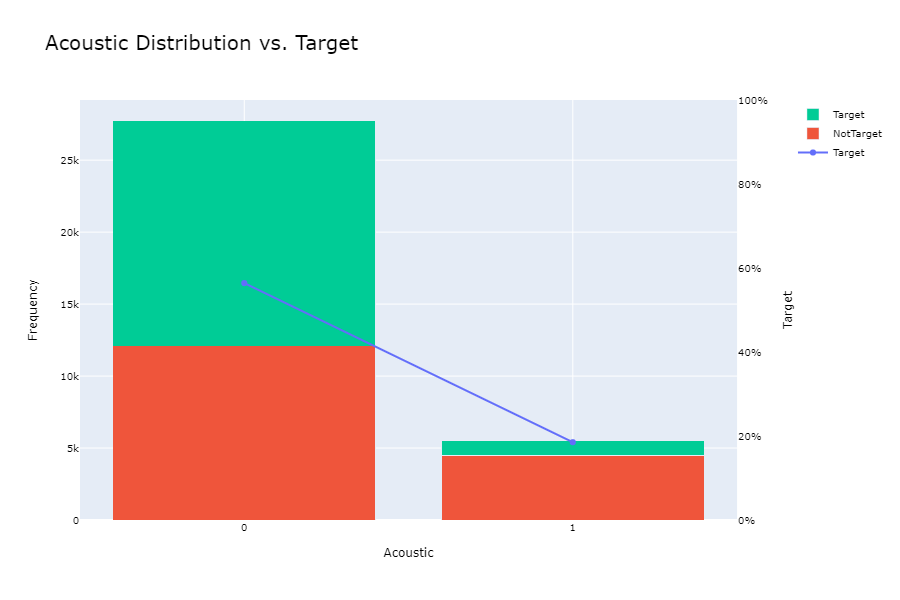

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




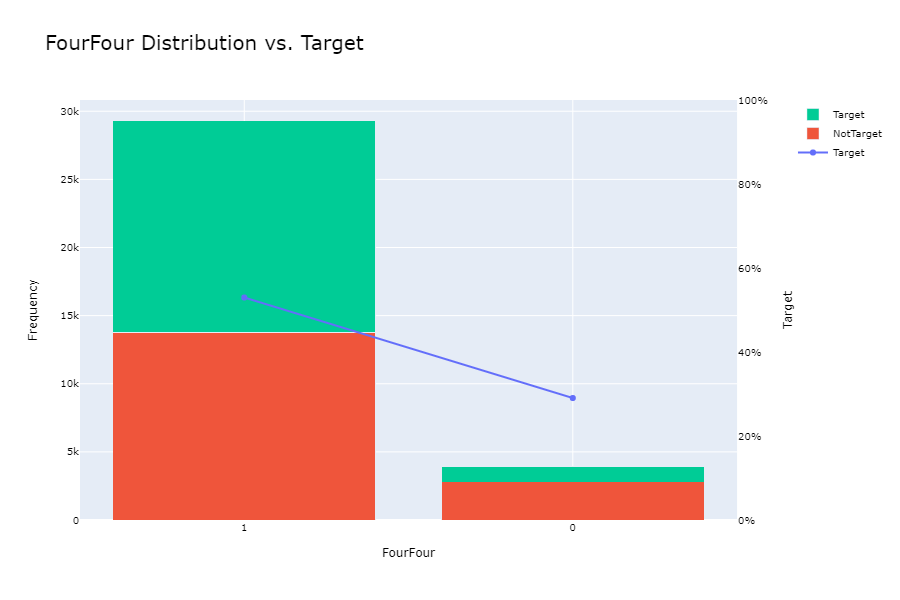

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




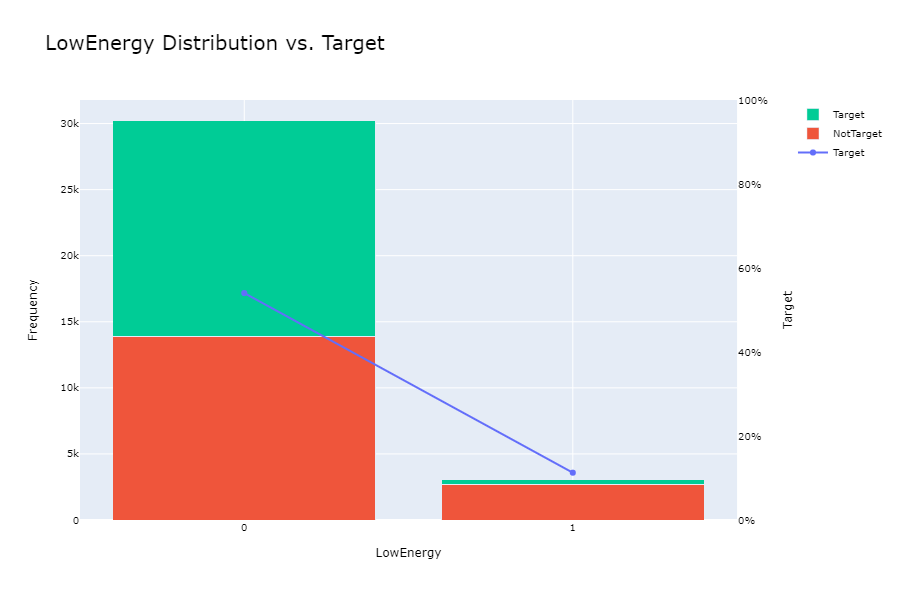

In [12]:
for Variable in DiscreteVars:
    Distribution(Train, "Target", Variable)

OPTIMAL
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.39217666
    IV (Jeffrey)             0.61491640
    JS (Jensen-Shannon)      0.06747540
    HHI                      0.04026042
    HHI (normalized)         0.01203278
    Cramer's V               0.35258069
    Quality score            0.00000000

  Significance tests

     Bin A  Bin B  t-statistic   p-value  P[A > B]  P[B > A]
         0      1    17.975558  0.000022  0.000003  0.999997
         1      2     0.610362  0.434652  0.222057  0.777943
         2      3     2.524822  0.112067  0.053749  0.946251
         3      4     9.053043  0.002623  0.000941  0.999059
         4      5     3.523739  0.060496  0.028840  0.971160
         5      6     0.023780  0.877445  0.443127  0.556873
         6      7     2.514050  0.112836  0.053691  0.946309
         7      8     0.786990  0.375012  0

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




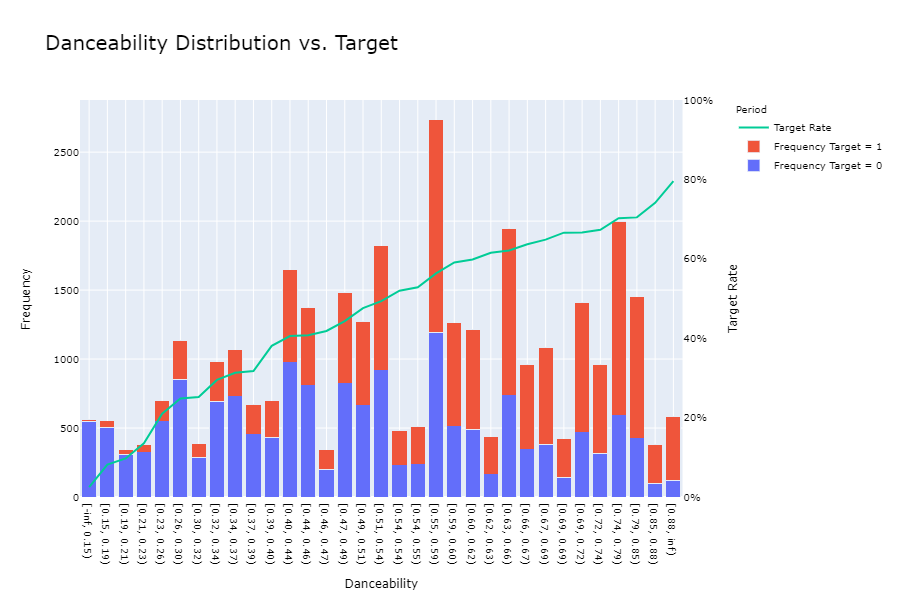

FEASIBLE
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.36960053
    IV (Jeffrey)             0.66528528
    JS (Jensen-Shannon)      0.07046358
    HHI                      0.05600506
    HHI (normalized)         0.02650521
    Cramer's V               0.35664587
    Quality score            0.00000024

  Significance tests

     Bin A  Bin B  t-statistic       p-value  P[A > B]      P[B > A]
         0      1     0.859363  3.539169e-01  0.162350  8.376500e-01
         1      2     7.974637  4.743726e-03  0.001530  9.984703e-01
         2      3    11.103304  8.617408e-04  0.000311  9.996889e-01
         3      4     7.080983  7.790627e-03  0.003447  9.965532e-01
         4      5     5.314438  2.114942e-02  0.009951  9.900493e-01
         5      6     3.213809  7.301932e-02  0.035931  9.640694e-01
         6      7    10.040090  1.531697e-03  0

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




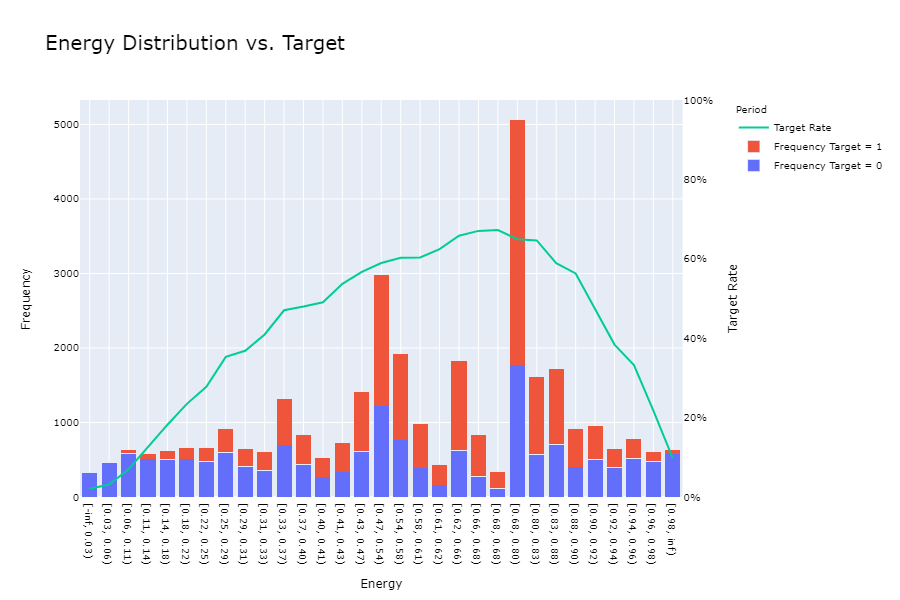

FEASIBLE
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.28801316
    IV (Jeffrey)             0.58943498
    JS (Jensen-Shannon)      0.05516249
    HHI                      0.11582856
    HHI (normalized)         0.08425101
    Cramer's V               0.30958388
    Quality score            0.00000009

  Significance tests

     Bin A  Bin B  t-statistic   p-value      P[A > B]  P[B > A]
         0      1    18.990218  0.000013  2.305086e-07  1.000000
         1      2     4.581934  0.032311  1.797158e-02  0.982028
         2      3     6.312810  0.011987  5.321775e-03  0.994678
         3      4     2.201947  0.137837  6.878436e-02  0.931216
         4      5     2.040059  0.153204  7.582561e-02  0.924174
         5      6     4.100307  0.042875  1.925269e-02  0.980747
         6      7     5.072237  0.024312  1.202933e-02  0.987971
         7

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




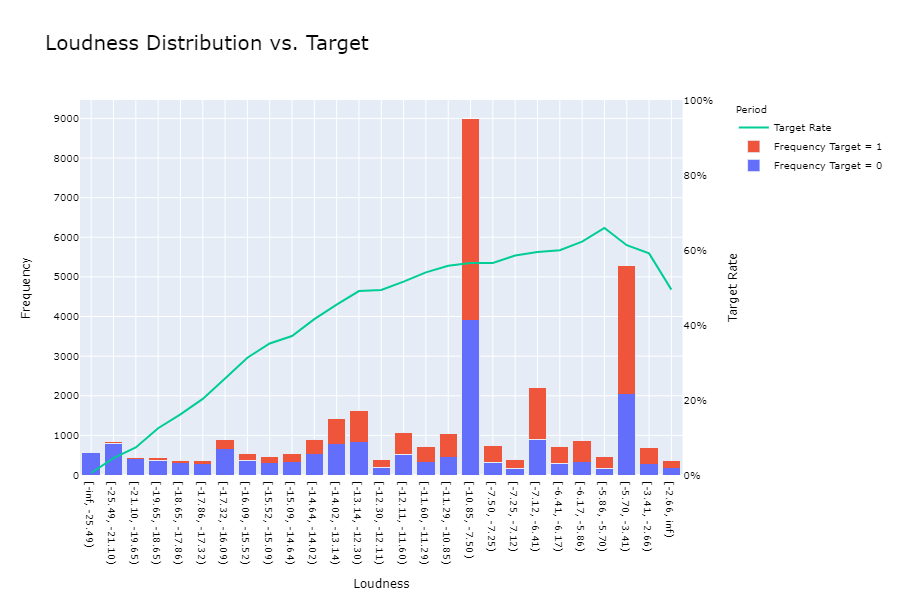

OPTIMAL
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.16788639
    IV (Jeffrey)             0.14100620
    JS (Jensen-Shannon)      0.01707195
    HHI                      0.34213668
    HHI (normalized)         0.30558872
    Cramer's V               0.18204521
    Quality score            0.00000747

  Significance tests

     Bin A  Bin B  t-statistic   p-value  P[A > B]      P[B > A]
         0      1     4.345950  0.037097  0.983080  1.692035e-02
         1      2     0.856530  0.354711  0.822931  1.770688e-01
         2      3     5.943323  0.014773  0.992950  7.049625e-03
         3      4     0.677231  0.410542  0.796727  2.032734e-01
         4      5     1.394149  0.237706  0.881286  1.187138e-01
         5      6     0.054983  0.814609  0.590635  4.093649e-01
         6      7     0.069904  0.791477  0.605354  3.946458e-01
         7 

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




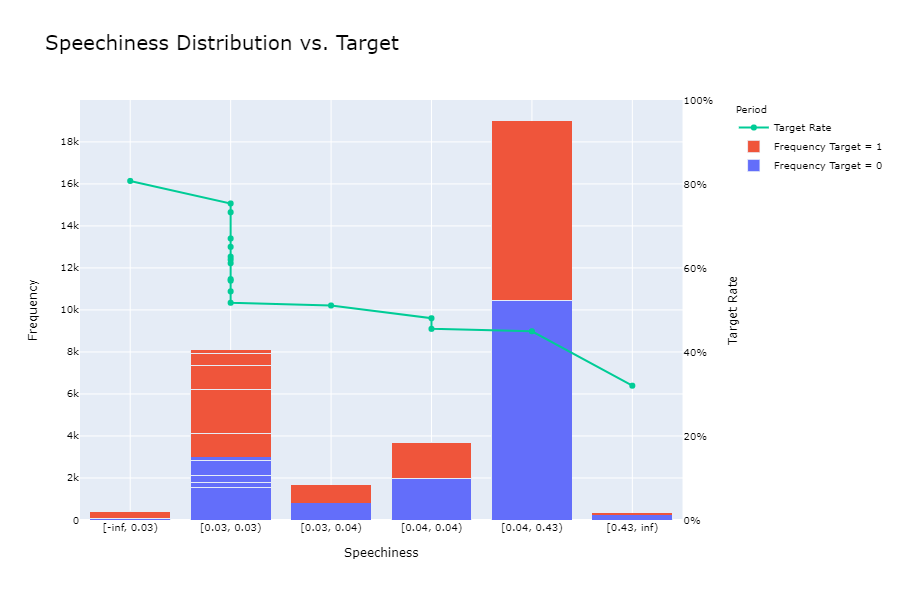

FEASIBLE
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.44723714
    IV (Jeffrey)             0.97139377
    JS (Jensen-Shannon)      0.09573971
    HHI                      0.03394837
    HHI (normalized)         0.00917782
    Cramer's V               0.41128873
    Quality score            0.00000000

  Significance tests

     Bin A  Bin B  t-statistic       p-value      P[A > B]      P[B > A]
         0      1    41.187600  1.382971e-10  5.121467e-13  1.000000e+00
         1      2     1.216168  2.701139e-01  1.342512e-01  8.657488e-01
         2      3    16.174075  5.777949e-05  1.370469e-05  9.999863e-01
         3      4     2.546588  1.105327e-01  5.407096e-02  9.459290e-01
         4      5     1.302548  2.537483e-01  1.269166e-01  8.730834e-01
         5      6     9.570935  1.976821e-03  8.571265e-04  9.991429e-01
         6      7  

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




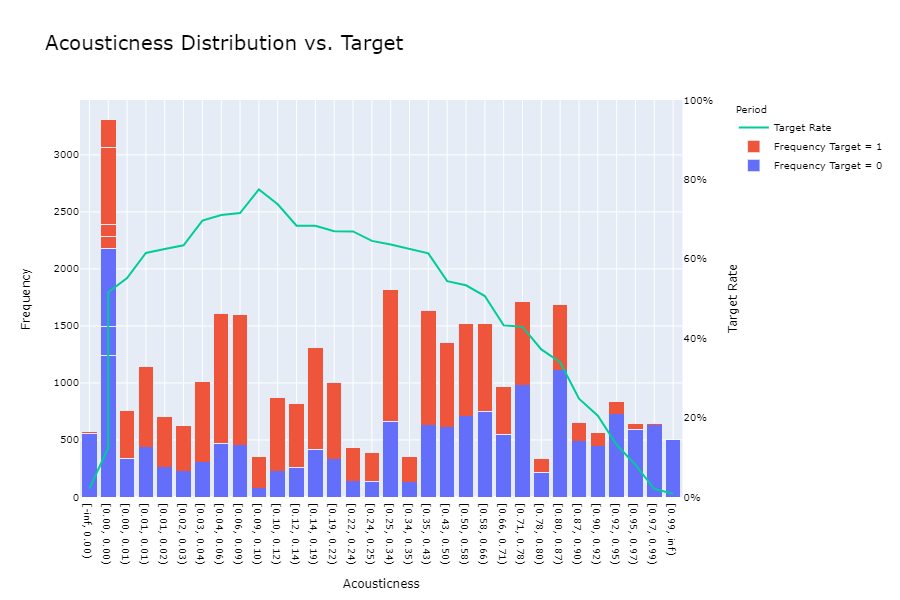

OPTIMAL
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.47848827
    IV (Jeffrey)             1.09619617
    JS (Jensen-Shannon)      0.11495400
    HHI                      0.11405329
    HHI (normalized)         0.07997842
    Cramer's V               0.45246391
    Quality score            0.00000045

  Significance tests

     Bin A  Bin B  t-statistic   p-value  P[A > B]      P[B > A]
         0      1    23.505228  0.000001  1.000000  3.389759e-09
         1      2     0.045936  0.830293  0.583427  4.165734e-01
         2      3     2.495334  0.114184  0.943745  5.625532e-02
         3      4     0.389446  0.532591  0.731527  2.684734e-01
         4      5     0.853965  0.355433  0.824280  1.757199e-01
         5      6     1.875464  0.170851  0.914532  8.546754e-02
         6      7     1.066917  0.301643  0.849327  1.506734e-01
         7 

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




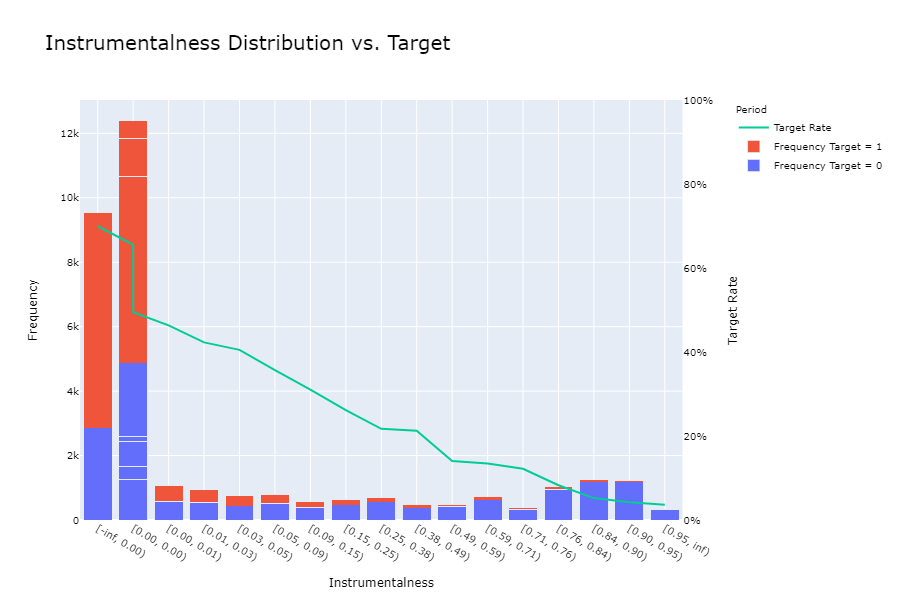

OPTIMAL
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.09361305
    IV (Jeffrey)             0.05190797
    JS (Jensen-Shannon)      0.00638954
    HHI                      0.41638821
    HHI (normalized)         0.36775390
    Cramer's V               0.11218176
    Quality score            0.00113133

  Significance tests

     Bin A  Bin B  t-statistic   p-value  P[A > B]      P[B > A]
         0      1     4.028381  0.044741  0.978474  2.152611e-02
         1      2     3.956477  0.046691  0.976691  2.330878e-02
         2      3     0.027398  0.868531  0.564973  4.350268e-01
         3      4     5.480030  0.019235  0.990798  9.201579e-03
         4      5     0.404487  0.524781  0.737699  2.623007e-01
         5      6     0.063943  0.800369  0.599706  4.002944e-01
         6      7     2.718228  0.099208  0.950444  4.955601e-02
         7 

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




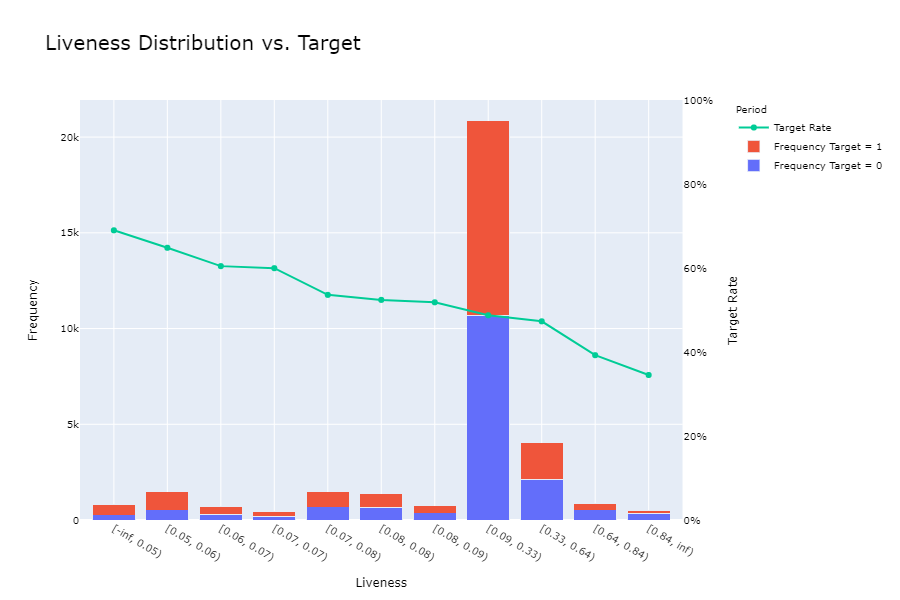

OPTIMAL
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.28296623
    IV (Jeffrey)             0.50116148
    JS (Jensen-Shannon)      0.04713337
    HHI                      0.07294534
    HHI (normalized)         0.03431806
    Cramer's V               0.28746273
    Quality score            0.00001273

  Significance tests

     Bin A  Bin B  t-statistic   p-value  P[A > B]  P[B > A]
         0      1    10.086046  0.001494  0.000365  0.999635
         1      2    13.468443  0.000243  0.000040  0.999960
         2      3    10.930005  0.000946  0.000409  0.999591
         3      4     6.780143  0.009218  0.003656  0.996344
         4      5     4.016868  0.045047  0.022595  0.977405
         5      6     6.226822  0.012583  0.005694  0.994306
         6      7     4.543303  0.033048  0.016142  0.983858
         7      8     0.812761  0.367305  0

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




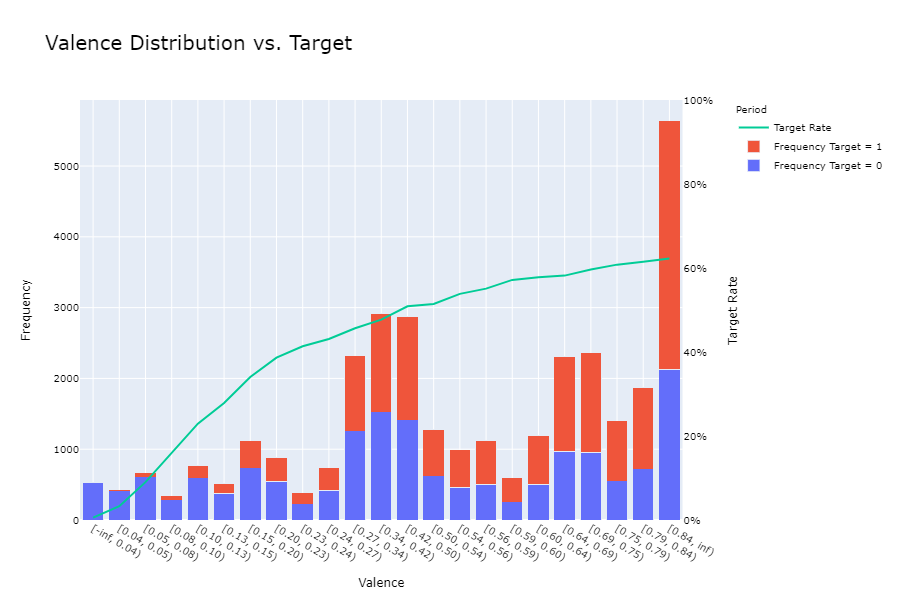

FEASIBLE
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.10547455
    IV (Jeffrey)             0.05508542
    JS (Jensen-Shannon)      0.00661489
    HHI                      0.09147917
    HHI (normalized)         0.04366228
    Cramer's V               0.11306670
    Quality score            0.00000054

  Significance tests

     Bin A  Bin B  t-statistic       p-value      P[A > B]  P[B > A]
         0      1    12.673358  3.709028e-04  1.202693e-04  0.999880
         1      2    38.942532  4.364667e-10  5.538219e-11  1.000000
         2      3     0.034311  8.530458e-01  4.269008e-01  0.573099
         3      4     4.421690  3.548486e-02  1.749800e-02  0.982502
         4      5     0.684171  4.081540e-01  2.040998e-01  0.795900
         5      6     1.176951  2.779775e-01  1.387648e-01  0.861235
         6      7     0.956185  3.281499e-01  1

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




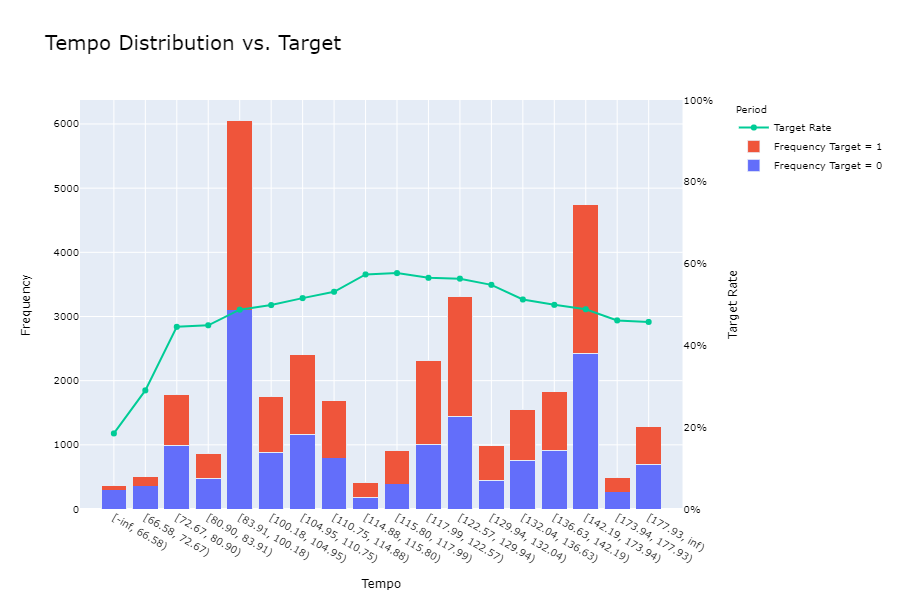

FEASIBLE
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.28537351
    IV (Jeffrey)             0.51358607
    JS (Jensen-Shannon)      0.04934919
    HHI                      0.08544768
    HHI (normalized)         0.05157537
    Cramer's V               0.29440712
    Quality score            0.00000041

  Significance tests

     Bin A  Bin B  t-statistic       p-value      P[A > B]      P[B > A]
         0      1     8.888541  2.869660e-03  3.818468e-04  9.996182e-01
         1      2    26.899406  2.143248e-07  8.238827e-09  1.000000e+00
         2      3    49.960667  1.568590e-12  1.756411e-16  1.000000e+00
         3      4     7.417308  6.459941e-03  2.867950e-03  9.971321e-01
         4      5    10.061889  1.513679e-03  6.073687e-04  9.993926e-01
         5      6     0.005956  9.384866e-01  4.694985e-01  5.305015e-01
         6      7  

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




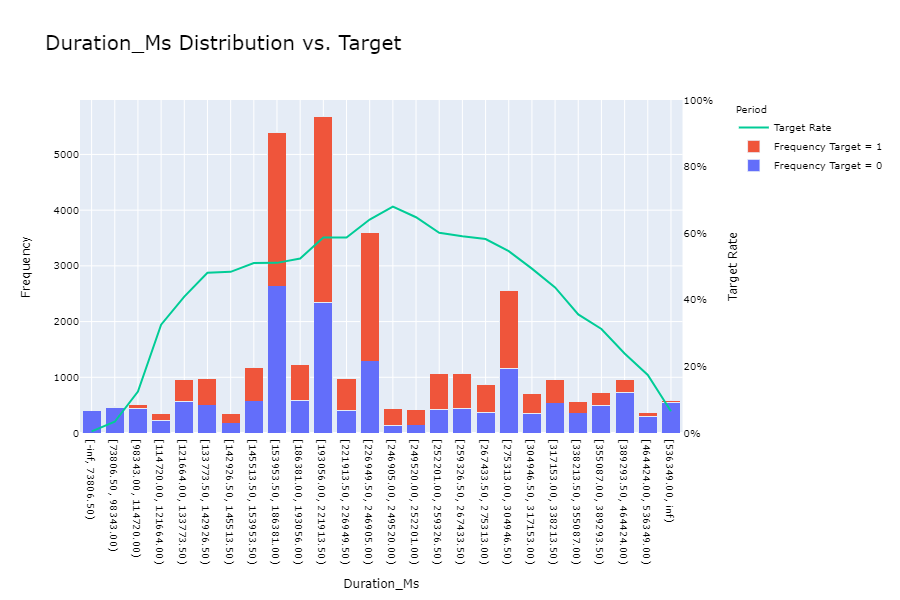

UNKNOWN
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.00000000
    IV (Jeffrey)             0.00000000
    JS (Jensen-Shannon)      0.00000000
    HHI                      1.00000000
    HHI (normalized)         1.00000000
    Cramer's V               0.00000000
    Quality score            0.00000000

  Significance tests

    None

None


C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




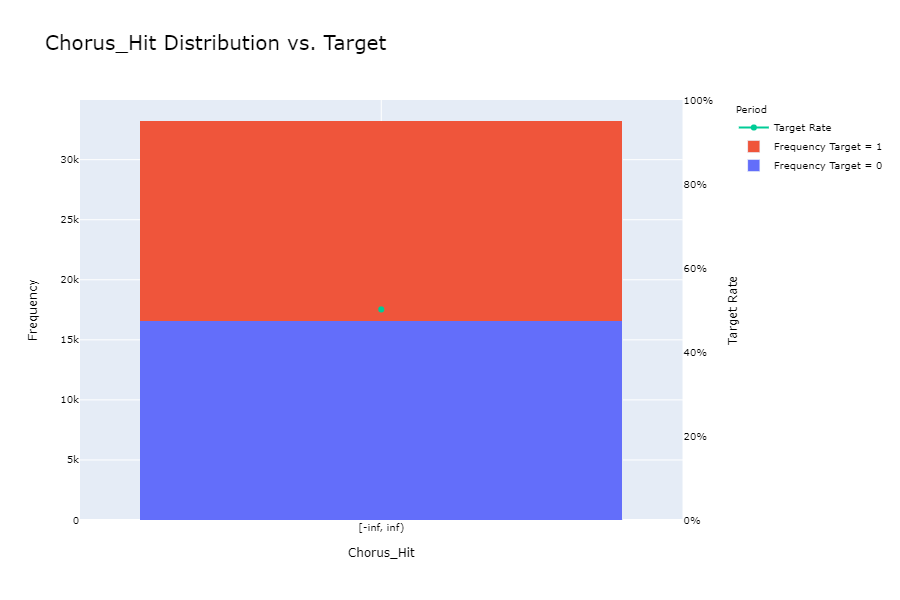

OPTIMAL
---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.23349954
    IV (Jeffrey)             0.33148016
    JS (Jensen-Shannon)      0.03565248
    HHI                      0.08946879
    HHI (normalized)         0.04154610
    Cramer's V               0.25381707
    Quality score            0.37654616

  Significance tests

     Bin A  Bin B  t-statistic       p-value      P[A > B]  P[B > A]
         0      1    11.467584  7.082069e-04  1.904664e-04  0.999810
         1      2    45.854551  1.273669e-11  9.586456e-14  1.000000
         2      3    60.243265  8.382917e-15  3.419154e-17  1.000000
         3      4    28.226775  1.079016e-07  1.407864e-08  1.000000
         4      5    13.140415  2.889939e-04  1.072806e-04  0.999893
         5      6    14.568088  1.351846e-04  4.232049e-05  0.999958
         6      7     2.648135  1.036715e-01  5.

C:\Users\tom.dawson\AppData\Local\Continuum\anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




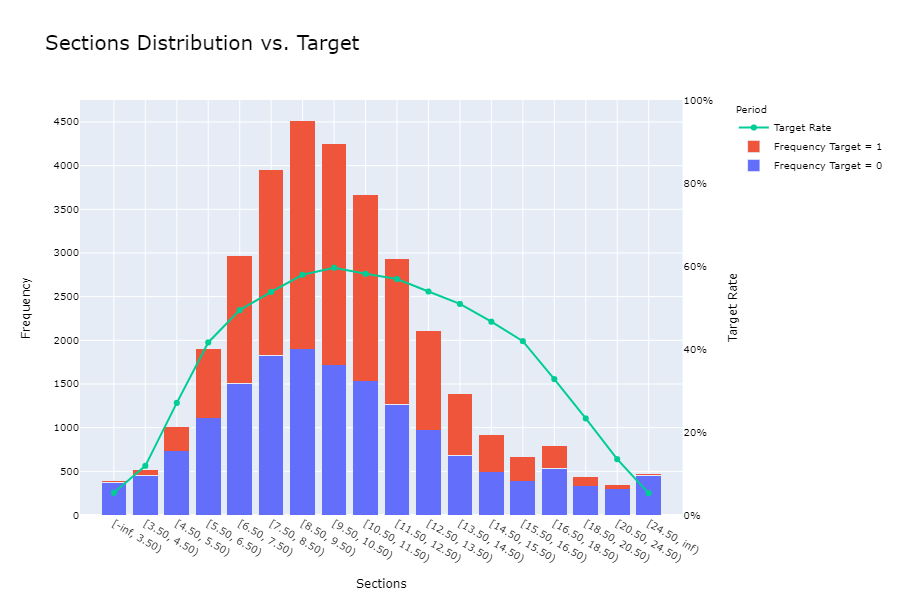

In [13]:
BinOut = {}

for Variable in ContinuousVars:
    BinOut = BinVariable(Train, "Target", Variable, BinOut, Trend="auto")

In [40]:
Variables = ["Mode", "Acoustic", "FourFour", "LowEnergy", "Liveness", "Instrumentalness", "Danceability"]

SquareVariables = ["Loudness", "Duration_Ms", "Energy", "Acousticness", "Tempo", "Sections"]

SqrtVariables = ["Valence"]

OrdinalVariables = ["Key"]

ModVars = Variables+SquareVariables+SqrtVariables+OrdinalVariables
ModVarsClean = [str(Variable)+"Clean" for Variable in ModVars]

In [15]:
for Variable in ModVars:
    Train[Variable+"Clean"] = Train[Variable]
    Test[Variable+"Clean"] = Test[Variable]

In [16]:
for Variable in ContinuousVars:
    
    Bins = BinOut[Variable].tolist()
    Bins.insert(0, -np.inf)
    Bins.insert(len(Bins), np.inf)
    
    Train[Variable + "Clean"] = pd.cut(Train[Variable], bins=Bins, labels = range(0, len(Bins)-1)).values
    Test[Variable + "Clean"] = pd.cut(Test[Variable], bins=Bins, labels = range(0, len(Bins)-1)).values

In [17]:
for Variable in ModVarsClean:
    Train[Variable]  = pd.to_numeric(Train[Variable])
    Test[Variable]  = pd.to_numeric(Test[Variable])

for Variable in SquareVariables:
    Train[str(Variable)+"SquaredClean"] = Train[Variable+"Clean"]**2
    Test[str(Variable)+"SquaredClean"] = Test[Variable+"Clean"]**2
    ModVarsClean.append(str(Variable)+"SquaredClean")
    
for Variable in SqrtVariables:
    Train[str(Variable)+"SqrtClean"] = Train[Variable+"Clean"]**0.5
    Test[str(Variable)+"SqrtClean"] = Test[Variable+"Clean"]**0.5
    ModVarsClean.append(str(Variable)+"SqrtClean")
    
for Variable in OrdinalVariables:
    Index = pd.pivot_table(Train, index=Variable, values="Target", aggfunc="mean").sort_values(by="Target", ascending=False).index.values
    Labels = {}
    for i in range(len(Index)):
        Labels[Index[i]] = i

    Train[str(Variable)+"Clean"] = Train.Key.map(Labels)
    Test[str(Variable)+"Clean"] = Test.Key.map(Labels)

In [18]:
for Variable in ModVarsClean:
    Scaler = MinMaxScaler(feature_range=(-1, 1))
    Scaler = Scaler.fit(Train[Variable].values.reshape(-1, 1))
    Train[Variable] = Scaler.transform(Train[Variable].values.reshape(-1, 1))
    Test[Variable] = Scaler.transform(Test[Variable].values.reshape(-1, 1))

## Variable Correlations

In [41]:
Correlation(Train, sorted(ModVarsClean)+["Target"], "CorrelationPlot")

In [44]:
OverFit = []
for i in Train.columns:
    Counts = Train[i].value_counts()
    Zeros = Counts.iloc[0]
    if Zeros / len(Train) * 100 > 99.94:
        OverFit.append(i)
        print(Counts)

OverFit = list(OverFit)
print(OverFit)
#Train = Train.drop(OverFit, axis=1)
#print(Train.shape)

Train    33220
Name: Population, dtype: int64
-1.0    33220
Name: Chorus_HitClean, dtype: int64
-1.0    33220
Name: Chorus_HitSquaredClean, dtype: int64
['Population', 'Chorus_HitClean', 'Chorus_HitSquaredClean']


## Modelling

In [45]:
X = ['AcousticClean', 'DanceabilityClean', 'Duration_MsClean', 'Duration_MsSquaredClean'
                , 'EnergyClean', 'EnergySquaredClean', 'FourFourClean', 'InstrumentalnessClean', 'KeyClean'
                , 'LivenessClean', 'LoudnessClean', 'LoudnessSquaredClean', 'LowEnergyClean', 'ModeClean'
                , 'SectionsClean', 'SectionsSquaredClean', 'ValenceClean', 'ValenceSqrtClean']

Y = "Target"

In [46]:
Scores = {}
Precisions = {}
Recalls = {}
Aucs = {}

### Logistic Regression

In [47]:
Mod = LogisticRegression(penalty='l1', solver='liblinear', fit_intercept=True)
Mod = Mod.fit(Train[X], Train[Y])
TrainPreds = Mod.predict(Train[X])
TestPreds = Mod.predict(Test[X])

In [48]:
FeatureImportance = {}
for i in range(len(X)):
    FeatureImportance[X[i]] = np.abs(Mod.coef_[0][i])
FeatureImportance = pd.DataFrame(FeatureImportance, index=[1,])
FeatureImportance = FeatureImportance.T.sort_values(by=1).T

In [49]:
Aucs["LogisticRegressionTrain"] = roc_auc_score(TrainPreds, Train[Y])
Recalls["LogisticRegressionTrain"] = recall_score(TrainPreds, Train[Y])
Precisions["LogisticRegressionTrain"] = precision_score(TrainPreds, Train[Y])
Scores["LogisticRegressionTrain"] = accuracy_score(TrainPreds, Train[Y])

Aucs["LogisticRegressionTest"] = roc_auc_score(TestPreds, Test[Y])
Recalls["LogisticRegressionTest"] = recall_score(TestPreds, Test[Y])
Precisions["LogisticRegressionTest"] = precision_score(TestPreds, Test[Y])
Scores["LogisticRegressionTest"] = accuracy_score(TestPreds, Test[Y])

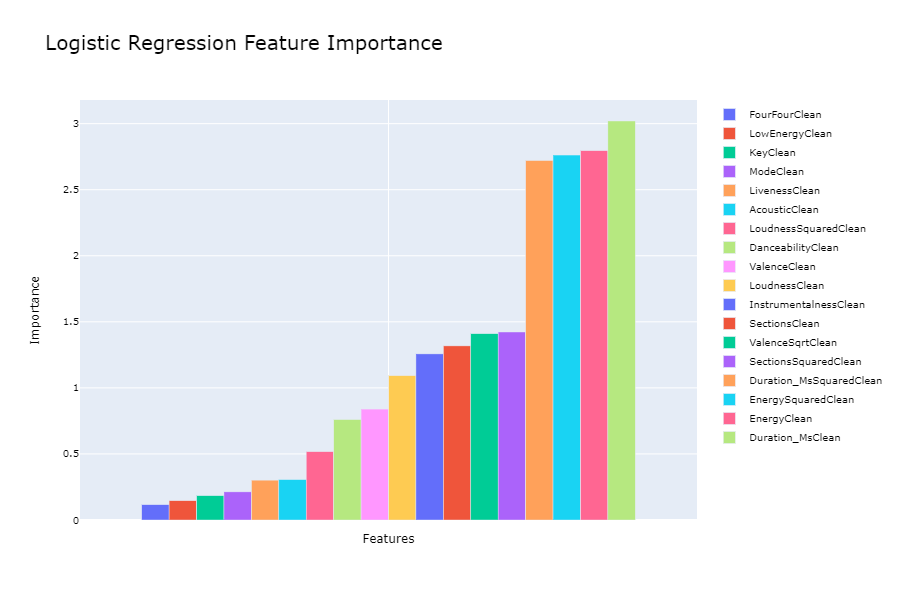

In [50]:
BarPlot(FeatureImportance, "Logistic Regression Feature Importance")

### Decision Tree

In [51]:
ParamGrid = {'max_depth': np.arange(3, 10)
             , 'min_samples_split': [int(0.01*len(Train)*i) for i in range(1, 10)]
            }

Mod = GridSearchCV(tree.DecisionTreeClassifier(), ParamGrid, cv=5)

Mod = Mod.fit(Train[X], Train[Y])

print('Decision Tree Best Params: {}'.format(Mod.best_params_))

Mod = tree.DecisionTreeClassifier(max_depth = Mod.best_params_["max_depth"]
                                  , min_samples_split = Mod.best_params_["min_samples_split"])
Mod = Mod.fit(Train[X], Train[Y])
TrainPreds = Mod.predict(Train[X])
TestPreds = Mod.predict(Test[X])

Decision Tree Best Params: {'max_depth': 7, 'min_samples_split': 332}


In [52]:
Aucs["DecisionTreeTrain"] = roc_auc_score(TrainPreds, Train[Y])
Recalls["DecisionTreeTrain"] = recall_score(TrainPreds, Train[Y])
Precisions["DecisionTreeTrain"] = precision_score(TrainPreds, Train[Y])
Scores["DecisionTreeTrain"] = accuracy_score(TrainPreds, Train[Y])

Aucs["DecisionTreeTest"] = roc_auc_score(TestPreds, Test[Y])
Recalls["DecisionTreeTest"] = recall_score(TestPreds, Test[Y])
Precisions["DecisionTreeTest"] = precision_score(TestPreds, Test[Y])
Scores["DecisionTreeTest"] = accuracy_score(TestPreds, Test[Y])

In [53]:
FeatureImportance = {}
for i in range(len(X)):
    FeatureImportance[X[i]] = np.abs(Mod.feature_importances_[i])
FeatureImportance = pd.DataFrame(FeatureImportance, index=[1,])
FeatureImportance = FeatureImportance.T.sort_values(by=1).T

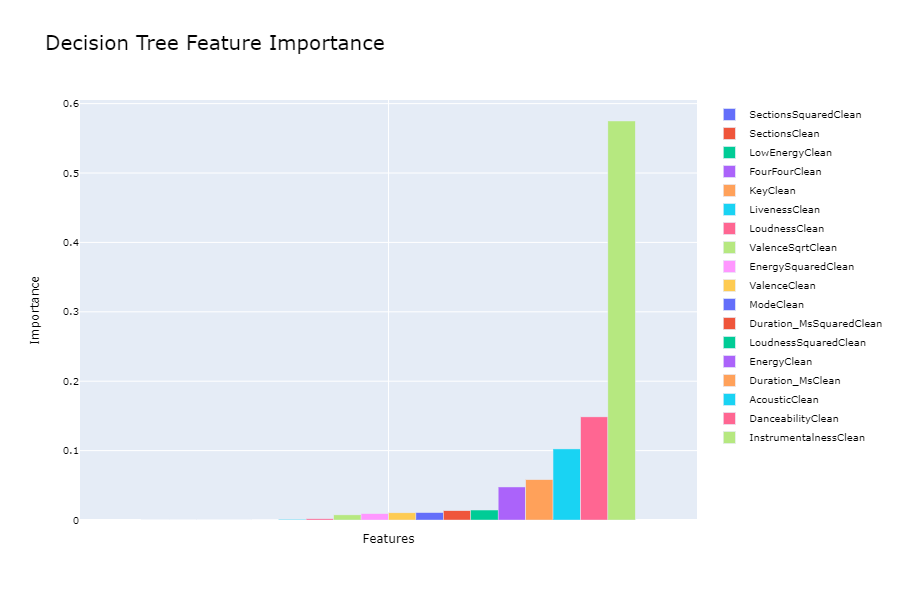

In [54]:
BarPlot(FeatureImportance, "Decision Tree Feature Importance")

### Support Vector Classifer

In [39]:
X = ['Duration_MsClean', 'Duration_MsSquaredClean', 'EnergyClean', 'EnergySquaredClean']

Y = "Target"

In [ ]:
ParamGrid = [
    {'C': [1, 10, 100, 1000], 'kernel': ['linear']}
    , {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]


Mod = RandomizedSearchCV(svm.SVC(), ParamGrid, cv=5)

Mod = Mod.fit(Train[X], Train[Y])

print('Support Vector Classifier Best Params: {}'.format(Mod.best_params_))

Mod = svm.SVC()

Mod = Mod.fit(Train[X], Train[Y])
TrainPreds = Mod.predict(Train[X])
TestPreds = Mod.predict(Test[X])

In [ ]:
Aucs["DecisionTreeTrain"] = roc_auc_score(TrainPreds, Train[Y])
Recalls["DecisionTreeTrain"] = recall_score(TrainPreds, Train[Y])
Precisions["DecisionTreeTrain"] = precision_score(TrainPreds, Train[Y])
Scores["DecisionTreeTrain"] = accuracy_score(TrainPreds, Train[Y])

Aucs["DecisionTreeTest"] = roc_auc_score(TestPreds, Test[Y])
Recalls["DecisionTreeTest"] = recall_score(TestPreds, Test[Y])
Precisions["DecisionTreeTest"] = precision_score(TestPreds, Test[Y])
Scores["DecisionTreeTest"] = accuracy_score(TestPreds, Test[Y])

In [ ]:
FeatureImportance = {}
for i in range(len(X)):
    FeatureImportance[X[i]] = np.abs(Mod.feature_importances_[i])
FeatureImportance = pd.DataFrame(FeatureImportance, index=[1,])
FeatureImportance = FeatureImportance.T.sort_values(by=1).T

In [ ]:
BarPlot(FeatureImportance, "SCV Feature Importance")